# Домашнее задание

В этом домашнем задании перед вами стоит задача научиться по фотографии лица человека предсказывать его пол, расу и возраст.

[Датасет](https://susanqq.github.io/UTKFace/), который мы будем использовать состоит из 20000 фотографий лиц людей в возрасте от 0 до 116 лет! В качестве разметки имеется пол (male/female), раса (white/black/asian/indian/other) и возраст. Классификация с настолько сильной внутриклассовой изменьчивостью (от младенцев до пожилых людей!) -- очень сложная задача. 
![alt text](https://susanqq.github.io/UTKFace/icon/samples.png)

Мы немного упростим себе задачу и воспользуемся версией датасета, где все картинки приведены к одному размеру и лица находятся в центре изображения.

Как решать такую задачу? Мы предлагаем вам воспользоваться **transfer learning и finetuning**. Т.е. взять за основу сеть, обученную на большом количестве данных для другой задачи и дообучить ее для нашей задачи.

*Это достаточно объемное и сложное домашнее задание, но не пугайтесь --  вы уже обладаете всеми знаниями, которые необходимы для его решения. Отметим, что уметь дообучить сеть является необходимим навыком на практике.*

## Задание 1

Датасетом, с которого чаще всего "переносят" знания, является известный нам ImageNet. Работая над классификатором кошек и собак на прошлом уроке мы воспользовались именно им. В этом задании мы возьмем за основу сеть, которая была обучена на датасете [VGGFace2](http://www.robots.ox.ac.uk/~vgg/data/vgg_face2/) для классификации лиц. Он содержит 3.3 миллиона изображений с 9000 разными персоналиями. **Почему мы сделали выбор в пользу VGGFace2?**

**ВПИШИТЕ ОТВЕТ ЗДЕСЬ**

**-----**

*Возможный ответ: Датасет VGGFace2 гораздо ближе к нашей задаче. Значит, признаки которые он научился извлекать из изображений будут нам горазддо полезне и помогут обучить модель лучше и быстрее*

**-----**




Ответ:

для сужения выборки




А теперь перейдем к практической части домашнего задания. Для начала загрузим модель, которую будем дообучать -- это мы сделали за вас. Пожалуйста, просмотрите код и комментарии внимательно.

## Загрузка обученной модели

Сеть, которую мы будем дообучать мы возьмем из открытого источника: https://github.com/rcmalli/keras-vggface .

In [1]:
! pip install git+https://github.com/rcmalli/keras-vggface.git

  Cloning https://github.com/rcmalli/keras-vggface.git to /tmp/pip-req-build-xjmzsn7e
  Running command git clone -q https://github.com/rcmalli/keras-vggface.git /tmp/pip-req-build-xjmzsn7e
  Created wheel for keras-vggface: filename=keras_vggface-0.6-py3-none-any.whl size=8325 sha256=92a82f14d33eaeb0251707bbb4710d7330f1ee43fdf3b60b58418935bef7e99c
  Stored in directory: /tmp/pip-ephem-wheel-cache-cib7gz_c/wheels/08/df/86/0225d44647ab2256dbf1e006823288fe9cc86367a056e6ea2c
Successfully built keras-vggface


In [2]:
!pip install keras==2.3.0 --user #- нужна версия keras==2.3.0 

In [ ]:
!pip install tensorflow==2.3.3 --user #- нужна версия tensorflow==2.3.3

In [ ]:
import os
os.kill(os.getpid(), 9)

In [3]:
import tensorflow as tf
#tf.enable_eager_execution()
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pathlib
from pathlib import Path
import os

In [4]:
import keras

Using TensorFlow backend.


In [5]:
print(keras.__version__)

2.3.0


In [6]:
print(tf.__version__)

2.3.3


In [7]:
tf.executing_eagerly()

True

Т.к. мы решили воспользоваться чужой моделью, нам нужно сначала понять как с ней взаимодействовать. Для этого авторы часто прикладывают пример использования своих моделей. Его можно найти в README у автора репозитория.

In [8]:
# код из https://github.com/rcmalli/keras-vggface/blob/master/README.md
# при выполнении вызовет ошибку -- это нормально

from keras_vggface.vggface import VGGFace

vggface = VGGFace(model='resnet50') # or VGGFace() as default

AttributeError: ignored

Ошибка появляется потому что, пример из репозитория не использует режим eager_execution, который мы всегда включали в своих примерах для удобства разработки и соответствия новым стандартам tensorflow. 

Но это не проблема. Мы за вас заранее выполнили код выше без eager_execution и сохранили модель с помощью save_model. Она находится по адресу: https://drive.google.com/open?id=1oHJxVZCcVwp1dgcwDIZL4h97uInxOGWO . Загрузим модель:


In [9]:
! pip install gdown
import gdown

url = 'https://drive.google.com/uc?id=1oHJxVZCcVwp1dgcwDIZL4h97uInxOGWO'
output = 'resnet50face.h5'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1oHJxVZCcVwp1dgcwDIZL4h97uInxOGWO
To: /content/resnet50face.h5
166MB [00:00, 172MB/s]


'resnet50face.h5'

In [10]:
from tensorflow.keras.models import load_model
vggface_model = load_model("resnet50face.h5")

Модель загружена, а теперь посмотрим, что она из себя представляет. Это архитектура -- ResNet. На самом деле внутренности модели не очень важны для нас -- в дальнейшем мы заморозим бОльшую часть этой сети и будем рабоать только с последними слоями. Нам важно, что она обучена и мы имеем доступ к ее архитектуре и весам.

In [ ]:
vggface_model.summary() # последний слой классифицирует на 8631 классов

Для проверки того, что помимо архитектуры мы правильно загрузили веса, проверим предсказания модели на следующем изображении: 

In [12]:
! wget https://img.joinfo.ua/i/2019/01/5c4ea940d2b08.jpg -O brad_pitt.jpg

--2021-09-15 08:59:18--  https://img.joinfo.ua/i/2019/01/5c4ea940d2b08.jpg
Resolving img.joinfo.ua (img.joinfo.ua)... 172.67.214.206, 104.21.83.52, 2606:4700:3035::ac43:d6ce, ...
Connecting to img.joinfo.ua (img.joinfo.ua)|172.67.214.206|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://img.joinfo.com/i/2019/01/5c4ea940d2b08.jpg [following]
--2021-09-15 08:59:18--  https://img.joinfo.com/i/2019/01/5c4ea940d2b08.jpg
Resolving img.joinfo.com (img.joinfo.com)... 104.21.29.70, 172.67.148.145, 2606:4700:3032::ac43:9491, ...
Connecting to img.joinfo.com (img.joinfo.com)|104.21.29.70|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 43154 (42K) [image/jpeg]
Saving to: ‘brad_pitt.jpg’

brad_pitt.jpg       100%[===================>]  42.14K  --.-KB/s    in 0.01s   

2021-09-15 08:59:18 (4.05 MB/s) - ‘brad_pitt.jpg’ saved [43154/43154]



После загрузки запустим полный пример из репозитория:

1351680/1346516 [==============================] - 0s 0us/step


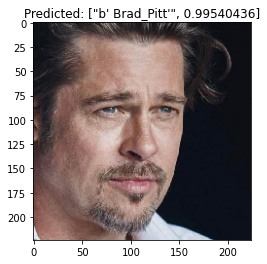

In [13]:
from keras_vggface import utils
from tensorflow.keras.preprocessing import image

img = image.load_img("brad_pitt.jpg", target_size=(224, 224)) # модель работает с картинками размера 224 на 224
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = utils.preprocess_input(x, version=2) # мы fиспользуем resnet50 -- поэтому version2. Эта функция нам еще пригодится!

preds = vggface_model.predict(x) # модель -- известная нам keras model, вызываем predict
plt.title(f"Predicted: {utils.decode_predictions(preds)[0][0]}") # используем  decode_predictions из keras_vggface
plt.imshow(img)

## Загрузка данных
Мы убедились, что модель загружена правильно, узнали какой препроцессинг ей необходим (utils.preprocess_input(x, version=2)) и теперь можем перейти к загрузке наших данных.

In [14]:
from pathlib import Path
from collections import Counter

In [15]:
url = 'https://drive.google.com/uc?id=0BxYys69jI14kYVM3aVhKS1VhRUk'
output = '/tmp/UTKFace.tar.gz'
gdown.download(url, output, quiet=False)
! tar -xzf /tmp/UTKFace.tar.gz -C /tmp/

Downloading...
From: https://drive.google.com/uc?id=0BxYys69jI14kYVM3aVhKS1VhRUk
To: /tmp/UTKFace.tar.gz
107MB [00:00, 191MB/s] 


In [16]:
url = 'https://drive.google.com/uc?id=1mux7xiP4NP6AUUFvUW42RgSdUEQ4k5e2'
output = 'train_val_split_utk.csv'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1mux7xiP4NP6AUUFvUW42RgSdUEQ4k5e2
To: /content/train_val_split_utk.csv
100%|██████████| 1.08M/1.08M [00:00<00:00, 63.6MB/s]


'train_val_split_utk.csv'

In [17]:
data_folder = Path("/tmp/UTKFace/")
filenames = list(map(lambda x: x.name, data_folder.glob('*.jpg')))
print(len(filenames))
print(filenames[:3]) # имя файла содержит возраст, индекс пола и расы, перечисленные через нижнее подчеркивание

23708
['25_0_0_20170119145504925.jpg.chip.jpg', '18_1_0_20170103201500071.jpg.chip.jpg', '36_0_0_20170104173002256.jpg.chip.jpg']


In [18]:
# формируем датафрейм с путями и нужными классами
np.random.seed(10)
np.random.shuffle(filenames)
gender_mapping = {0: 'Male', 1: 'Female'}
race_mapping = dict(list(enumerate(('White', 'Black', 'Asian', 'Indian', 'Others'))))
age_labels, gender_labels, race_labels, correct_filenames = [], [], [], []

for filename in filenames:
    if len(filename.split('_')) != 4:
        print(f"Bad filename {filename}")
        continue

    age, gender, race, _ = filename.split('_')
    correct_filenames.append(filename)
    age_labels.append(age)
    gender_labels.append(gender)
    race_labels.append(race)
    
age_labels = np.array(age_labels, dtype=np.float32)
max_age = age_labels.max()
data = {"img_name": correct_filenames, 
        "age": age_labels / max_age, # нормализуем возраст от 0 до 1
        "race": race_labels, 
        "gender": gender_labels}
df = pd.DataFrame(data)
df.head()

Bad filename 61_1_20170109142408075.jpg.chip.jpg
Bad filename 61_1_20170109150557335.jpg.chip.jpg
Bad filename 39_1_20170116174525125.jpg.chip.jpg


,img_name,age,race,gender
0,34_0_0_20170117182649925.jpg.chip.jpg,0.293103,0,0
1,49_0_3_20170119205458583.jpg.chip.jpg,0.422414,3,0
2,25_0_1_20170116001049632.jpg.chip.jpg,0.215517,1,0
3,8_1_3_20170104222709156.jpg.chip.jpg,0.068966,3,1
4,26_1_1_20170113000509698.jpg.chip.jpg,0.224138,1,1


In [19]:
df_split = pd.read_csv("train_val_split_utk.csv", index_col=0).set_index("img_name")
df_split.head()
df = df.set_index("img_name").join(df_split).reset_index()
df_train = df[df["is_train"] == 1]
df_val = df[df["is_train"] != 1]
print(len(df_val), len(df_train))

4759 18946


In [20]:
def decode_labels(race_id, gender_id, age):
    return race_mapping[int(race_id)], gender_mapping[int(gender_id)], int(age*max_age)
def show_face(image, race_id, gender_id, age):
    plt.imshow(image)
    race, gender, age = decode_labels(race_id, gender_id, age)
    plt.title(f"Gender: {gender}, Race: {race}, Age: {age}")

Убедимся, что метки классов корректны:

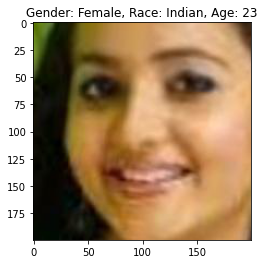

In [21]:
row = df.iloc[np.random.randint(len(df))]
img = plt.imread(str(data_folder / row["img_name"]))
show_face(img, row["race"], row["gender"], row["age"])

Посмотрим на их распределение:

Counter({'White': 10078, 'Black': 4526, 'Indian': 3975, 'Asian': 3434, 'Others': 1692})
Counter({'Male': 12391, 'Female': 11314})


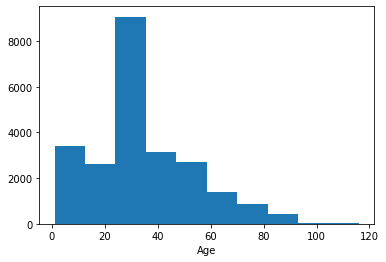

In [22]:
races_verbose = [race_mapping[int(race)] for race in df["race"]]
genders_verbose = [gender_mapping[int(gender)] for gender in df["gender"]]
from collections import Counter
print(Counter(races_verbose))
print(Counter(genders_verbose))
_ = plt.hist(df["age"]*max_age)
_ = plt.xlabel("Age")

## Задание 2. Создание генератора данных для модели предсказания пола.
Предподготовка закончена. А теперь ваша очередь:) Мы начнем с создания модели предсказания пола. В этом задании вы должны реализовать генератор данных необходимый для последущего обучения модели. Мы предлагаем вам воспользоваться `tensorflow.keras.preprocessing.image.ImageDataGenerator`

### a) 
**Создайте генератор image_gen типа ImageDataGenerator с корректным препроцессингом, соответствующем keras_vggface.** Аугментацию использовать не нужно. 

Какой препроцессинг корректный? Как мы знаем, перед применением обученных сетей нужно знать какой препроцессинг они проводят с данными. Т.к. эта модель не часть Keras, мы должны ответить на этот вопрос сами с помощью исходников автора этой сети. К счастью, он приводит пример использования на главной странице репозитория. Видно, что он использует функцию preprocess_input из utils. Значит ей мы и должны воспользоваться!

In [23]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def preprocess_input_facenet(image_):
    """
    image_ -- тензор размера (1, H, W, 3)
    
    return: картинка, с примененным preprocess_input(..., version=2) из keras_vggface (см пример с Бредом Питом)
    """
    # < YOUR CODE STARTS HERE >
  
    preprocessed = utils.preprocess_input(image_, version=2) # мы используем resnet50 -- поэтому version2.
    
    # < YOUR CODE ENDS HERE >
    return preprocessed

# < YOUR CODE STARTS HERE >
# image_gen должен содержать ImageDataGenerator с правильной preprocessing_function

image_gen = ImageDataGenerator(preprocessing_function=preprocess_input_facenet)

# < YOUR CODE ENDS HERE >

### b)

Для генерации картинок раньше мы использовали `image_gen.flow_from_folder`. Но для этого данные должны быть расположены на диске с определенной структурой папок, что в данном случае не очень удобно. Поэтому вы должны воспользоваться более гибким `image_gen.flow_from_dataframe`, который позволяет генерировать данные с нужными классами используя датафрейм (мы его создали выше для вас).

**Ознакомьтесь с документацией по [ссылке](https://keras.io/preprocessing/image/) (раздел flow_from_dataframe) и создайте train_generator и val_generator для df_train и df_val соответственно.**
*  Генератор должен возвращать картинку и ее класс (male/female)
*  class_mode укажите "binary", directory=str(data_folder)
*  batch_size, image_size указаны ниже
*  train_generator должен перемешивать данные, а val_generator -- не должен
*  После выполнения клетки ниже вы должны увидеть текст: *Found 18946 validated image filenames belonging to 2 classes.
Found 4759 validated image filenames belonging to 2 classes.*




In [24]:
df_train.head()

,img_name,age,race,gender,is_train
0,34_0_0_20170117182649925.jpg.chip.jpg,0.293103,0,0,1
1,49_0_3_20170119205458583.jpg.chip.jpg,0.422414,3,0,1
3,8_1_3_20170104222709156.jpg.chip.jpg,0.068966,3,1,1
5,25_1_2_20170116174820922.jpg.chip.jpg,0.215517,2,1,1
7,31_0_2_20170116170946512.jpg.chip.jpg,0.267241,2,0,1


In [25]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

BATCH_SIZE = 128
IMAGE_SIZE = 224
# < YOUR CODE STARTS HERE >
# train_generator = image_gen.flow_from_dataframe( ... ), 
# val_generator = image_gen.flow_from_dataframe( ... )

train_generator = image_gen.flow_from_dataframe( 
    color_mode='rgb',
    dataframe=df_train,
    directory=str(data_folder),
    x_col="img_name",
    y_col="gender",
    class_mode="binary",
    batch_size=BATCH_SIZE,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    shuffle=True)


val_generator = image_gen.flow_from_dataframe( 
    color_mode='rgb',
    dataframe=df_val,
    directory=str(data_folder),
    x_col="img_name",
    y_col="gender",
    class_mode="binary",
    batch_size=BATCH_SIZE,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    shuffle=False)

# < YOUR CODE ENDS HERE >

Found 18946 validated image filenames belonging to 2 classes.
Found 4759 validated image filenames belonging to 2 classes.


In [26]:
sample_images, sample_labels = next(val_generator)
assert sample_images.shape == (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, 3), "Неправильный размер батча"
assert sample_labels.shape == (BATCH_SIZE,), "Неправильный размер меток класса"
assert list(sorted(np.unique(sample_labels))) == [0., 1.], "Ожидаемые классы 0 и 1"
print("Simple tests passed")

Simple tests passed


Попробуем отобразить картинку и ее лейбл для проверки генерации:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Female


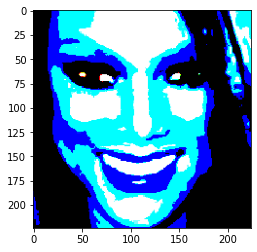

In [27]:
plt.imshow(sample_images[100])
print(gender_mapping[int(sample_labels[100])])
# мы получим очень странное изображение и это нормально. 
# matplotlib ожидает картинку с интесивностями от 0 до 1 если она типа float и от 0 до 255 если int.

In [28]:
type(sample_images[100])

numpy.ndarray

In [29]:
print(sample_images[100].max(), sample_images[100].min()) # можно увидеть что значения яркостей типа float и в т.ч. отрицательные

132.11731 -131.0912


### с)
**Реализуйте функцию `deprocess_image`, которая преобразует картинку исользуемую keras_vggface обратно к изображению, которое можно визуализировать с помощью `matplotlib`.**
*  вам понадобится https://github.com/rcmalli/keras-vggface/blob/master/keras_vggface/utils.py
*  необходимо проделать операции preprocess_input в обратном порядке
*  наш случай: version=2, format="channels_last"

In [30]:
sample_images.shape

(128, 224, 224, 3)

In [31]:
sample_images[..., ::-1].shape

(128, 224, 224, 3)

In [32]:
sample_images[..., 0].shape

(128, 224, 224)

Female


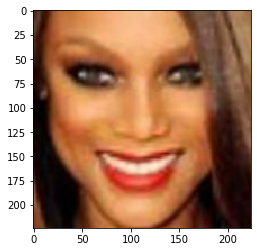

In [33]:
def deprocess_image(vggface_image):
    """
    vggface_image -- (H, W, 3) картинка после препросессинга. 
    содержит отрицательные значения и некорректно отображается matplotlib

    return: корректно отображаеая картинка типа np.uint8(!!). 

    ! работайте с копией картинки (image = np.copy(vggface_image)) !
    """
    # < YOUR CODE STARTS HERE > 
    image = np.copy(vggface_image)
    x_temp = image
    x_temp = x_temp[..., ::-1]
    #  91.4953  103.8827 131.0912
    x_temp[..., 0] += 131.0912
    x_temp[..., 1] += 103.8827
    x_temp[..., 2] += 91.4953
    
    image = np.uint8(x_temp)
    #image = x_temp
    # < YOUR CODE ENDS HERE >
    return image

# теперь картинка должна отображаться корректно
plt.imshow(deprocess_image(sample_images[100]))
print(gender_mapping[int(sample_labels[100])])

In [34]:
np.uint8(-2)

254

In [35]:
print(sample_images[100].max(), sample_images[100].min()) # можно увидеть что значения яркостей типа float и в т.ч. отрицательные

132.11731 -131.0912


In [36]:
print(deprocess_image(sample_images[100]).max(), deprocess_image(sample_images[100]).min()) # можно увидеть что значения яркостей типа float и в т.ч. отрицательные

255 0


## Здание 3. Обучение модели предсказания пола

В этом задании вы должны обучить модель предсказания пола с точностью более 90% на валидационном сете. 

*   Возьмите за основу 'base_model' (определена ниже)
*   Вы должны сами решить сколько слоев замораживать и сколько полносвзяных слоев использовать. Рекомендуем начинать с модели с меньшим числом обучаемых параметров.
*   Используйте чекпоинты, чтобы не потерять веса лучшей модели. Они должны быть сохранены с именем "model_gender/checkpoint_best.h5"
*   Рекомендуется в model.fit(...) использовать steps_per_epoch=25, для того чтобы проверка на валидации происходила чаще и вы могли более точно отслеживать прогресс. Полная эпоха ~140 итераций.
*   За точность выше 94% -- дополнительные баллы.



In [37]:
!pip install livelossplot
from livelossplot.tf_keras import PlotLossesCallback

In [ ]:
# для начала "отрежем" от vggface_model последний слой классификатора 
# теперь для картинки base_model предсказывает 2048-мерный вектор признаков.

base_model = tf.keras.Model([vggface_model.input], vggface_model.get_layer("flatten_1").output)
base_model.summary()

In [ ]:
# < YOUR CODE STARTS HERE >

In [ ]:
base_model.trainable = False # замораживаем всю базовую модель
model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.Dense(1, activation='sigmoid')
])

# model.compile(optimizer = tf.keras.optimizers.Adam(lr=1e-5), 
#               loss='binary_crossentropy',
#               metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
functional_1 (Functional)    (None, 2048)              23561152  
_________________________________________________________________
dense (Dense)                (None, 1)                 2049      
Total params: 23,563,201
Trainable params: 2,049
Non-trainable params: 23,561,152
_________________________________________________________________


In [ ]:
# EPOCHS = 30
# history = model.fit_generator(
#     train_generator,
#     epochs=EPOCHS,
#     validation_data=val_generator,
#     callbacks=[PlotLossesCallback()])

In [ ]:
base_model.trainable = True
print("Количество слоев в базовой модели: ", len(base_model.layers))

Количество слоев в базовой модели:  175


In [ ]:
fine_tune_at = 150
# все слои до -- заморозим
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
functional_1 (Functional)    (None, 2048)              23561152  
_________________________________________________________________
dense (Dense)                (None, 1)                 2049      
Total params: 23,563,201
Trainable params: 8,931,329
Non-trainable params: 14,631,872
_________________________________________________________________


In [ ]:
# сохранение модели
dir_path = pathlib.Path.home()
cpt_filename = "gender_checkpoint_best.h5"  
cpt_path =str(dir_path / cpt_filename)

if os.path.isfile(cpt_path): # удаление файла, если есть
    os.remove(cpt_path)
        
checkpoint = tf.keras.callbacks.ModelCheckpoint(cpt_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')


In [ ]:
# модель сохранена в
cpt_path

'/root/gender_checkpoint_best.h5'

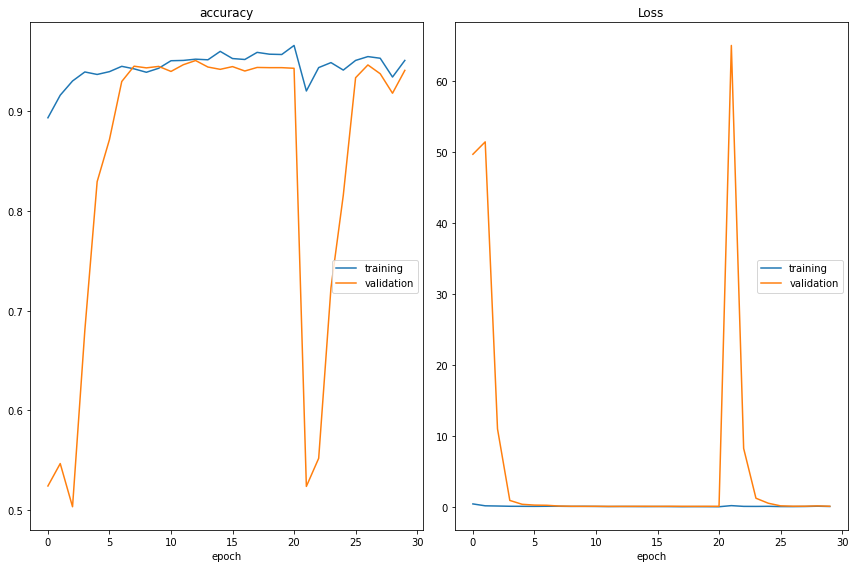

accuracy
	training         	 (min:    0.893, max:    0.966, cur:    0.951)
	validation       	 (min:    0.503, max:    0.951, cur:    0.941)
Loss
	training         	 (min:    0.092, max:    0.489, cur:    0.127)
	validation       	 (min:    0.141, max:   65.074, cur:    0.159)

Epoch 00030: val_accuracy did not improve from 0.95083
25/25 [==============================] - 48s 2s/step - loss: 0.1269 - accuracy: 0.9509 - val_loss: 0.1595 - val_accuracy: 0.9410


In [ ]:
model.compile(optimizer = tf.keras.optimizers.Adam(lr=1e-3), 
              loss='binary_crossentropy',
              metrics=['accuracy'])

EPOCHS = 30
history = model.fit_generator(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=[PlotLossesCallback(), checkpoint], 
    steps_per_epoch=25,)

In [ ]:
# < YOUR CODE ENDS HERE >

In [ ]:
model_gender = load_model(cpt_path)
loss, acc = model_gender.evaluate(val_generator)
if acc < 0.9:
    print("Please, try harder!")
else:
    if acc >= 0.94:
        print("Well done!")
    else:
        print("Very good! Can you improve accuracy?")

38/38 [==============================] - 26s 690ms/step - loss: 0.1416 - accuracy: 0.9508
Well done!


In [71]:
#@title (вспомогательный код, выполните клетку)
def show_faces(images, real_race=None, real_gender=None, real_age=None, 
               predicted_race=None, predicted_gender=None, predicted_age=None):
    plt.figure(figsize=(10,10))
    labels = {"Gender": [predicted_gender, real_gender],
                  "Race": [predicted_race, real_race],
                  "Age": [predicted_age, real_age]}
    for i in range(16):
        plt.subplot(4,4, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(deprocess_image(images[i]))
        real_str = "Real:"
        pred_str = "Pred:"
        correct = True
        for name, (predicted, real) in labels.items():
            if predicted is None:
                continue
            if name == "Age":
                real_age = int(real[i]*int(max_age))
                predicted_age = int(predicted[i]*max_age)
                real_str += f"{real_age}"
                pred_str += f"{predicted_age}"
                if np.abs(predicted_age - real_age) > 6:
                    correct = False

            elif name == "Gender":
                real_gender = int(real[i])
                predicted_gender = int(predicted[i] > 0.5)
                real_str += f"{gender_mapping[real_gender]}, "
                pred_str += f"{gender_mapping[predicted_gender]}, "
                if real_gender != predicted_gender:
                    correct = False
            elif name == "Race":
                real_race = int(real[i])
                predicted_race = np.argmax(predicted[i])
                real_str += f"{race_mapping[real_race]}, "
                pred_str += f"{race_mapping[predicted_race]}, "
                if real_race != predicted_race:
                    correct = False
                
        title_obj = plt.title(f"{real_str}\n{pred_str}")
            
        plt.subplots_adjust(wspace=0.4)
        if not correct:
            plt.setp(title_obj, color='r')
        

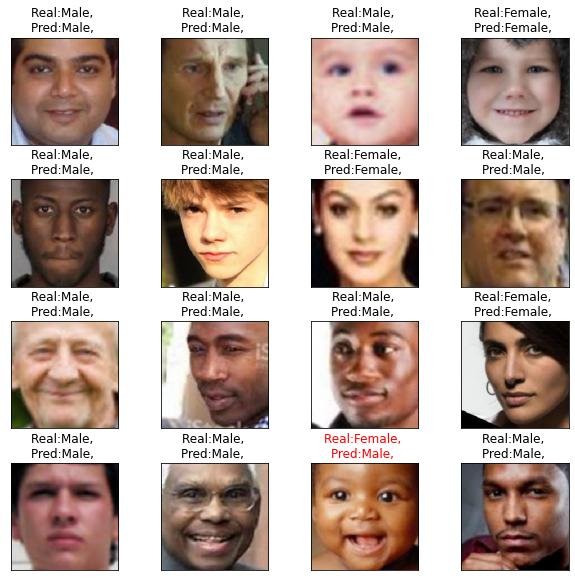

In [ ]:
sample_validation_images, sample_validation_labels = next(val_generator)
predicted = model_gender.predict(sample_validation_images)
show_faces(sample_validation_images, real_gender=sample_validation_labels, predicted_gender=predicted)

## Здание 4. Обучение модели предсказания расы

В этом задании вы должны обучить модель предсказания расы с точностью более 80% на валидационном сете. 

*   Используя код аналогичный тому, что выше, реализуйте модель предсказания расы
*   Для начала определите генератор данных
    *  нужно указать class_mode="sparse" и изменить "y_col"
*   Используйте чекпоинты, чтобы не потерять веса лучшей модели. Они должны быть сохранены с именем "model_race/checkpoint_best.h5"
*   За точность выше 85% -- дополнительные баллы.



In [ ]:
vggface_model = load_model("resnet50face.h5")
base_model = tf.keras.Model([vggface_model.input], vggface_model.get_layer("flatten_1").output)
base_model.trainable = False

In [ ]:
# < YOUR CODE STARTS HERE >

In [ ]:
# Обучение модели предсказания расы

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

BATCH_SIZE = 128
IMAGE_SIZE = 224

train_generator = image_gen.flow_from_dataframe( 
    color_mode='rgb',
    dataframe=df_train,
    directory=str(data_folder),
    x_col="img_name",
    y_col="race",
    class_mode="sparse",
    batch_size=BATCH_SIZE,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    shuffle=True)


val_generator = image_gen.flow_from_dataframe( 
    color_mode='rgb',
    dataframe=df_val,
    directory=str(data_folder),
    x_col="img_name",
    y_col="race",
    class_mode="sparse",
    batch_size=BATCH_SIZE,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    shuffle=False)


Found 18946 validated image filenames belonging to 5 classes.
Found 4759 validated image filenames belonging to 5 classes.


In [ ]:
base_model.trainable = False # замораживаем всю базовую модель
model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.Dense(5, activation='softmax')
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
functional_11 (Functional)   (None, 2048)              23561152  
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 10245     
Total params: 23,571,397
Trainable params: 10,245
Non-trainable params: 23,561,152
_________________________________________________________________


In [ ]:
# EPOCHS = 30
# history = model.fit_generator(
#     train_generator,
#     epochs=EPOCHS,
#     validation_data=val_generator,
#     callbacks=[PlotLossesCallback()])

In [ ]:
base_model.trainable = True
print("Количество слоев в базовой модели: ", len(base_model.layers))

Количество слоев в базовой модели:  175


In [ ]:
fine_tune_at = 150
# все слои до -- заморозим
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
functional_11 (Functional)   (None, 2048)              23561152  
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 10245     
Total params: 23,571,397
Trainable params: 8,939,525
Non-trainable params: 14,631,872
_________________________________________________________________


In [ ]:
# сохранение модели
dir_path = pathlib.Path.home()
cpt_filename = "race_checkpoint_best.h5"  
cpt_path =str(dir_path / cpt_filename)

if os.path.isfile(cpt_path): # удаление файла, если есть
    os.remove(cpt_path)
        
checkpoint = tf.keras.callbacks.ModelCheckpoint(cpt_path, monitor='val_sparse_categorical_accuracy', verbose=1, save_best_only=True, mode='max')


In [ ]:
# модель сохранена в
cpt_path

'/root/race_checkpoint_best.h5'

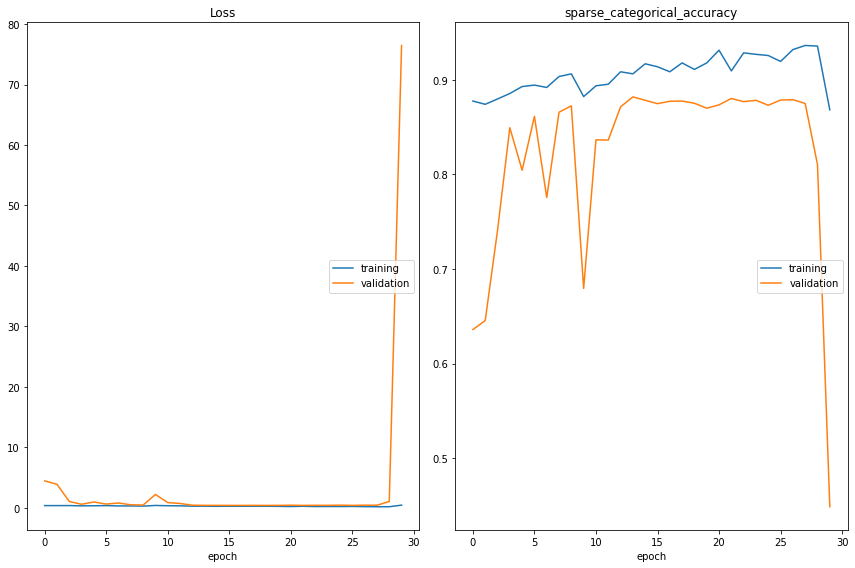

Loss
	training         	 (min:    0.183, max:    0.446, cur:    0.446)
	validation       	 (min:    0.401, max:   76.459, cur:   76.459)
sparse_categorical_accuracy
	training         	 (min:    0.868, max:    0.936, cur:    0.868)
	validation       	 (min:    0.449, max:    0.882, cur:    0.449)

Epoch 00030: val_sparse_categorical_accuracy did not improve from 0.88191
25/25 [==============================] - 48s 2s/step - loss: 0.4456 - sparse_categorical_accuracy: 0.8682 - val_loss: 76.4594 - val_sparse_categorical_accuracy: 0.4488


In [ ]:
model.compile(optimizer = tf.keras.optimizers.Adam(lr=1e-3), 
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

EPOCHS = 30
history = model.fit_generator(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=[PlotLossesCallback(), checkpoint], 
    steps_per_epoch=25,)

In [ ]:
# < YOUR CODE ENDS HERE >

In [ ]:
cpt_path

'/root/race_checkpoint_best.h5'

In [ ]:
model_race = load_model(cpt_path)
loss, acc = model_race.evaluate(val_generator)
if acc < 0.8:
    print("Please, try harder!")
else:
    if acc >= 0.85:
        print("Well done!")
    else:
        print("Very good! Can you improve accuracy?")

38/38 [==============================] - 26s 687ms/step - loss: 0.4085 - sparse_categorical_accuracy: 0.8819
Well done!


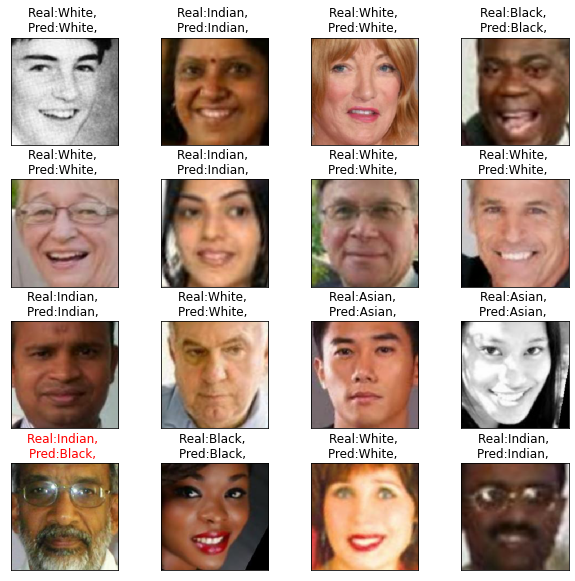

In [ ]:
sample_validation_images, sample_validation_labels = next(val_generator)
predicted = model_race.predict(sample_validation_images)
show_faces(sample_validation_images, real_race=sample_validation_labels, predicted_race=predicted)

## Задание 5. Multitask learning

В этом задании мы могли бы обучить регрессор возраста по картинке, используя аналогичный уже написаному код. Но вы пойдем по другому пути. 

Если на каждый атрибут (возраст, раса, пол) создавать одну модель, то таких моделей получится 3. Очевидно, что для предсказания на новой картике необходимо будет произвести инференс трех сетей. Это может быть ресурсо-затратно и сложнее в поддержке. 

Какой же есть еще подход? Он называется Multitask learning. Его идея в том, чтобы обучать одну модель для решения сразу нескольких задач! Гибкость нейронных сетей позволяет это сделать достаточно логичными образом. Необходимо вместо одной "головы" для предсказания сделать несколько. Таким образом в нашей задаче одна будет отвечать за классификацию пола (1 выход, вероятность), вторая -- за классификацию расы (5 выходов, вероятности) и третья -- за предсказания возраста (1 выход, число).

### a) 
**Реализуйте модель сети с тремя "головами".**

*    Вам нужно вспомнить что такое Functional API для определения моделей, потому что необходимо определить архитектуру с тремя выходами. С помощью Sequential API этого сделать нельзя.
*    За основу возьмите base_model (определена ниже), добавьте к ее выходу 1-2 полносвязных слоя (количество нейронов определите сами)
*    К последнему слою добавьте три паралельных выхода: два с одним нейроном и один с пятью
*    При определении выходных слоев обязательно укажите Dense(..., name="race"/"age"/"gender" )
*    Не забудьте про правильные активации. Т.к. возраст у нас нормирован (от 0 до 1), подумайте, какая активация ему подойдет
*    Порядок выходов модели: `outputs=[gender_output, race_output, age_output]`
*    Точность предсказания пола должна быть > 90%, расы > 80% а MAE для возраста < 0.09.

In [54]:
from tensorflow.keras.layers import Input
from tensorflow.keras.utils import plot_model

In [55]:
vggface_model = load_model("resnet50face.h5")
base_model = tf.keras.Model([vggface_model.input], vggface_model.get_layer("flatten_1").output)
base_model.trainable = False

In [56]:
input_layer = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

In [ ]:
# < YOUR CODE STARTS HERE >
# переменная model должна содержать модель для дальнейшего обучения

x = base_model(input_layer)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
gender_output = tf.keras.layers.Dense(1, activation='sigmoid', name="gender")(x)
race_output = tf.keras.layers.Dense(5, activation='softmax', name="race")(x)
age_output = tf.keras.layers.Dense(1, activation='sigmoid', name="age")(x)

model = tf.keras.Model(inputs=input_layer, outputs=[gender_output, race_output, age_output])

# < YOUR CODE ENDS HERE >
model.summary()
plot_model(model)


In [58]:
base_model.trainable = True
print("Количество слоев в базовой модели: ", len(base_model.layers))

Количество слоев в базовой модели:  175


In [59]:
fine_tune_at = 150
# все слои до -- заморозим
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False
model.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
functional_5 (Functional)       (None, 2048)         23561152    input_3[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 128)          262272      functional_5[0][0]               
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 128)          16512       dense_2[0][0]                    
_______________________________________________________________________________________

In [60]:
prediction = model(np.zeros((6, IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.float32))
assert len(prediction) == 3, "Модель должна возвращать три тензора"
assert prediction[0].shape == (6, 1), f"Неправильный размер выхода gender: {prediction[0].shape}"
assert prediction[1].shape == (6, 5), f"Неправильный размер выхода race: {prediction[1].shape}"
assert prediction[2].shape == (6, 1), f"Неправильный размер выхода age: {prediction[2].shape}"
print("Shape tests passed")

Shape tests passed


Ниже мы приводим необходимые генераторы данных. Обратите внимание на y_col и class_mode.


In [61]:
df_train.head()

,img_name,age,race,gender,is_train
0,34_0_0_20170117182649925.jpg.chip.jpg,0.293103,0,0,1
1,49_0_3_20170119205458583.jpg.chip.jpg,0.422414,3,0,1
3,8_1_3_20170104222709156.jpg.chip.jpg,0.068966,3,1,1
5,25_1_2_20170116174820922.jpg.chip.jpg,0.215517,2,1,1
7,31_0_2_20170116170946512.jpg.chip.jpg,0.267241,2,0,1


In [62]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18946 entries, 0 to 23704
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   img_name  18946 non-null  object 
 1   age       18946 non-null  float32
 2   race      18946 non-null  int64  
 3   gender    18946 non-null  int64  
 4   is_train  18946 non-null  int64  
dtypes: float32(1), int64(3), object(1)
memory usage: 814.1+ KB


In [63]:
df_train.race, df_train.gender = df_train.race.astype(int), df_train.gender.astype(int)
df_val.race, df_val.gender = df_val.race.astype(int), df_val.gender.astype(int)

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [ ]:
train_generator = image_gen.flow_from_dataframe(
        dataframe=df_train,
        class_mode="other", #other
        x_col="img_name", y_col=["gender", "race", "age"], # нас интересуют все три столбца
        directory=str(data_folder),
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        shuffle=True)
val_generator = image_gen.flow_from_dataframe(
        dataframe=df_val,
        class_mode="other", #other
        x_col="img_name", y_col=["gender", "race", "age"], 
        directory=str(data_folder),
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        shuffle=True)


In [65]:
def split_outputs(generator):
    """
    Вспомогательная функция, которая модернизирует генераторы картинок, чтобы их
    можно было использовать для Мultitask
    image_gen.flow_from_dataframe возвращает на каждой итерации батч:
    ((N, H, W, 3), (N, 3)) -- N картинок и N троек меток (для трех "задач")
    model.fit(..) ожидает генератор в формате:
    ((N, H, W, 3), [(N, 1), (N, 1), (N, 1)])

    Для такого превращения и нужна эта функция.

    """
    while True:
        data = next(generator)
        image = data[0]
        labels = np.split(data[1], 3, axis=1)
        yield image, labels

In [66]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001) # вы можете выбрать другую скорость обучения для вашей модели

# обратите внимание, что теперь loss -- это словарь, в котором к каждому выходу мы "прицепляем" свой лосс
# аналогично с metrics
model.compile(optimizer=optimizer, 
              loss={'gender': 'binary_crossentropy', 'race': 'sparse_categorical_crossentropy', 'age': 'mse'},
              metrics={'gender': 'accuracy', 'race': 'sparse_categorical_accuracy', 'age': 'mae'})

path = pathlib.Path.home()
cpt_filename = "model_multitask_checkpoint_best.h5"
cpt_path =str(path / cpt_filename)

checkpoint = tf.keras.callbacks.ModelCheckpoint(cpt_path, monitor='val_age_mae', verbose=1, save_best_only=True, mode='min')

In [67]:
cpt_path

'/root/model_multitask_checkpoint_best.h5'

А теперь перейдем к обучению:

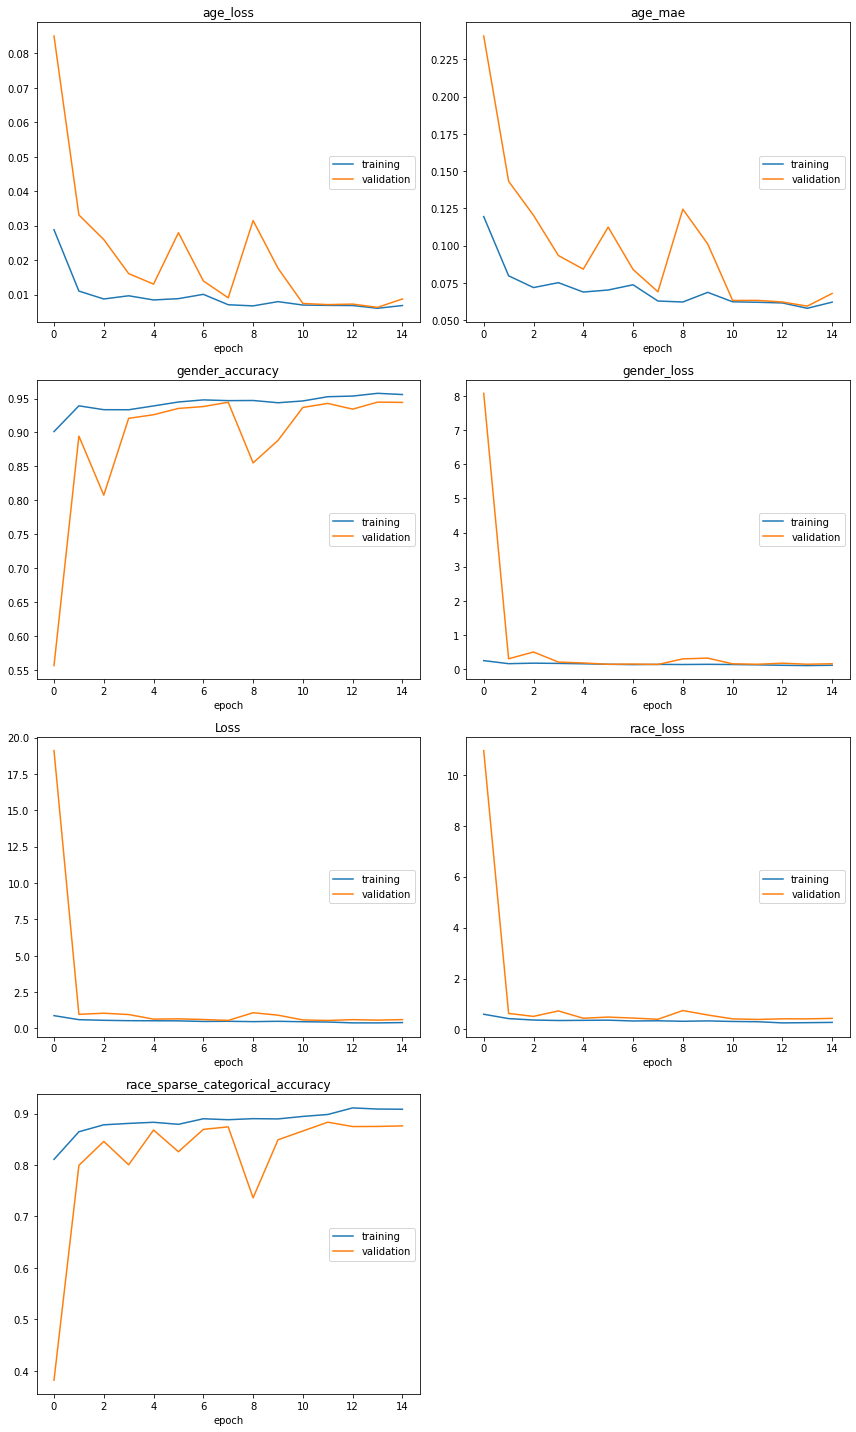

age_loss
	training         	 (min:    0.006, max:    0.029, cur:    0.007)
	validation       	 (min:    0.006, max:    0.085, cur:    0.009)
age_mae
	training         	 (min:    0.058, max:    0.119, cur:    0.062)
	validation       	 (min:    0.059, max:    0.241, cur:    0.068)
gender_accuracy
	training         	 (min:    0.901, max:    0.958, cur:    0.956)
	validation       	 (min:    0.557, max:    0.945, cur:    0.944)
gender_loss
	training         	 (min:    0.105, max:    0.250, cur:    0.114)
	validation       	 (min:    0.138, max:    8.075, cur:    0.159)
Loss
	training         	 (min:    0.379, max:    0.877, cur:    0.400)
	validation       	 (min:    0.545, max:   19.110, cur:    0.604)
race_loss
	training         	 (min:    0.260, max:    0.598, cur:    0.279)
	validation       	 (min:    0.394, max:   10.950, cur:    0.436)
race_sparse_categorical_accuracy
	training         	 (min:    0.811, max:    0.911, cur:    0.909)
	validation       	 (min:    0.382, max:    0.883

In [68]:
model.fit_generator(split_outputs(train_generator), epochs=15, validation_data=split_outputs(val_generator),
                    callbacks=[PlotLossesCallback(), checkpoint], steps_per_epoch=50, 
                    validation_steps= len(df_val) // BATCH_SIZE)

In [69]:
model_multitask = load_model(cpt_path)
val_generator = image_gen.flow_from_dataframe(
        dataframe=df_val,
        class_mode="other",
        x_col="img_name", y_col=["gender", "race", "age"], 
        directory=str(data_folder),
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        shuffle=True)
results = model.evaluate(split_outputs(val_generator), steps=len(df_val)//BATCH_SIZE)
assert results[-3] > 0.90, f"Gender accuracy is too low. Please try to improve it {results[-3]}"
assert results[-2] > 0.80, f"Race accuracy is too low. Please try to improve it. {results[-2]}"
assert results[-1] < 0.09, f"Age MAE it too high: {results[-1]}"
print("Well done!")

--- Logging error ---
Traceback (most recent call last):
  File "/usr/lib/python3.7/logging/__init__.py", line 1025, in emit
    msg = self.format(record)
  File "/usr/lib/python3.7/logging/__init__.py", line 869, in format
    return fmt.format(record)
  File "/usr/lib/python3.7/logging/__init__.py", line 608, in format
    record.message = record.getMessage()
  File "/usr/lib/python3.7/logging/__init__.py", line 369, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/usr/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.7/dist-packages/traitlets/config/application.py", line 845, in launch_instance
    app.start()
  File "/usr/local/lib/pytho

Found 4759 validated image filenames.
37/37 [==============================] - 28s 759ms/step - loss: 0.6043 - gender_loss: 0.1584 - race_loss: 0.4371 - age_loss: 0.0087 - gender_accuracy: 0.9447 - race_sparse_categorical_accuracy: 0.8763 - age_mae: 0.0679
Well done!


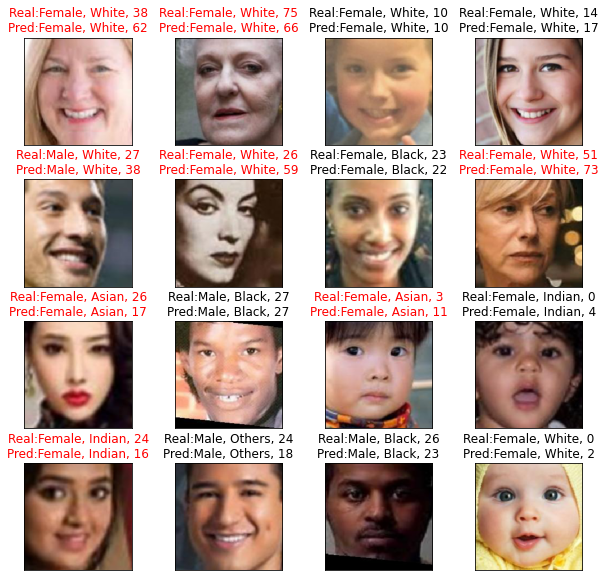

In [72]:
sample_validation_images, sample_validation_labels = next(split_outputs(val_generator))
predicted = model_multitask.predict(sample_validation_images)
show_faces(sample_validation_images, 
           real_gender=sample_validation_labels[0], predicted_gender=predicted[0],
           real_race=sample_validation_labels[1], predicted_race=predicted[1],
           real_age=sample_validation_labels[2].flatten(), predicted_age=predicted[2].flatten(),
           )

### b)
Загрузите любое лицо и получите предсказание. Не забудьте его обрезать соответствующим образом. Результат сети не оценивается.

Downloading...
From: https://drive.google.com/uc?id=1ZZgwwVxSjWG6gJT2uV2vt54QsLJcU07-
To: /content/me.jpg
2.34MB [00:00, 137MB/s]


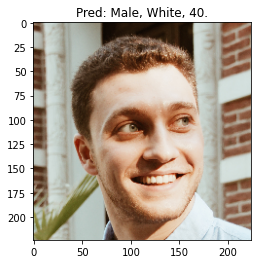

In [73]:
url = 'https://drive.google.com/uc?id=1ZZgwwVxSjWG6gJT2uV2vt54QsLJcU07-'
output = 'me.jpg'
gdown.download(url, output, quiet=False)

img = image.load_img("me.jpg", target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = utils.preprocess_input(x, version=2) 
predicted_labels = model.predict(x)
plt.imshow(img)
gender, race, age = int(predicted_labels[0][0] > 0.5), np.argmax(predicted_labels[1][0]), predicted_labels[2][0]
title_obj = f"Pred: {gender_mapping[gender]}, {race_mapping[race]}, {int(age[0]*max_age)}."
_ = plt.title(title_obj)
# я получился немного моложе :)

# Заключение 

Это было очень сложное и важное домашнее задание. Надеемся, вы с ним справились успешно и готовы к переходу к следующему модулю! Удачи!